In [29]:
import networkx as nx
import copy
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import sys
sys.path.insert(1, '../')
import tree_utils as tl

In [30]:
class Node:
    '''
    We want our node to have:
        - An edge label, e_i = (v, w)
        - A cc number
        - A comp set
        - A fps set
        - (more? maybe F_i?)
    '''
    def __init__(self, edge, cc=0, comp=set(), fps=set()):
        self.edge = edge
        self.cc = cc # are we sure we want to initialize to 0?
        self.comp = comp
        self.fps = fps
        self.paths = 0
    
    def summary(self):
        print(f" -- Node {self.edge}")
        print(f" --   cc {self.cc}")
        print(f" -- comp {self.comp}")
        print(f" --  fps {self.fps}")
        return

In [31]:
def tup(l):
    return tuple(sorted(l))

def tupUnion(s, t):
    return tup(set(s).union(set(t)))

In [32]:
def makeNewNode(edges, K, n, i, x):
    v, w = n.edge
    m = len(edges)
    n_prime = copy.deepcopy(n)
    
    # construct the frontiers
    def constructFrontiers(edges, i):
        m = len(edges)
        if i == 0:
            prevFrontier = set()
        else:
            processed_edges = [set(edges[j]) for j in range(i)]
            unprocessed_edges = [set(edges[j]) for j in range(i, m)]
            prevFrontier = set().union(*processed_edges) & set().union(*unprocessed_edges)
        
        if i == m:
            currFrontier = set()
        else:
            processed_edges = [set(edges[j]) for j in range(i+1)]
            unprocessed_edges = [set(edges[j]) for j in range(i+1, m)]
            currFrontier = set().union(*processed_edges) & set().union(*unprocessed_edges)
        return prevFrontier, currFrontier
    
    prevFrontier, currFrontier = constructFrontiers(edges, i)
    
    # if either of the vertices are entering the frontier, add them to comp
    for u in (v, w):
        if u not in prevFrontier:
            n_prime.comp.add(tup([u]))
    for vertex_set in n_prime.comp:
        if v in vertex_set:
            C_v = copy.copy(vertex_set) # not sure if copy is needed
        if w in vertex_set:
            C_w = copy.copy(vertex_set)

    # if we are adding this edge, the components should now be connected
    if x == 1:
        n_prime.comp.discard(C_v) # remove x if it exists
        n_prime.comp.discard(C_w)
        n_prime.comp.add(tupUnion(C_v, C_w))
        # if they are a forbidden pair, return 0
        if C_v != C_w and tup((C_v, C_w)) in n_prime.fps: # check ordering is ok
#             print(f"coming from node {n.edge}...")
#             print(f"FOUND A FORBIDDEN PAIR -- {C_v, C_w}")
            return 0
        # otherwise, replace all instances of C_v/C_w with their union in the fps
        else:
            fps_list = list(n_prime.fps)
            for elem in fps_list:
                new_elem = set(elem)
                if C_v in new_elem or C_w in new_elem:
                    if C_v in new_elem:
                        new_elem.remove(C_v)
                        new_elem.add(tupUnion(C_v, C_w))
                    if C_w in elem:
                        new_elem.remove(C_w)
                        new_elem.add(tupUnion(C_v, C_w)) # check to see if this doubling is ok
                    new_elem = tup(new_elem)
                    n_prime.fps.remove(elem)
                    n_prime.fps.add(new_elem)
                    
    else:
        # if we aren't adding this edge and the components are connected,
        # this violates induced subgraph, so return 0
        if C_v == C_w:
#             print(f"coming from node {n.edge}...")
#             print("violated induced subgraph")
            return 0
        # if they aren't connected, add their connected components to the fps
        else:
            n_prime.fps.add(tup((C_v, C_w)))
            
#     print(f"Vertices in prevFrontier: {prevFrontier}")
            
    
    # if either of the vertices are leaving the frontier...
    for u in (v, w):
#         print(f"currFrontier {currFrontier}")
#         print(f"n_prime.comp: {n_prime.comp}")
        if u not in currFrontier:
            # if u is an isolated component, increment our cc by 1
            if tup([u]) in n_prime.comp:
                n_prime.cc += 1
                # remove it from the range of the comp or fps's views...
                n_prime.comp.remove(tup([u]))
                # if we have too many cc's, return 0
                if n_prime.cc > max(K):
                    return 0
            
            # if u is a part of a connected component, take it out
            comp_list = list(n_prime.comp)
            for elem in comp_list:
                if u in elem:
                    new_elem = set(elem)
                    new_elem.remove(u)
                    new_elem = tup(new_elem)
                    n_prime.comp.remove(elem)
                    n_prime.comp.add(new_elem)
            
            # if {{u}, X} is in n_prime.fps for any X in n_prime.comp, take it out
            fps_list = list(n_prime.fps)
            for elem in fps_list:
                if tup([u]) in elem:
                    n_prime.fps.remove(elem)
                # same with u if it is a part of a vertex set in fps — this might be unnecessary or WRONG
                for vertex_set in elem:
                    if len(vertex_set) > 1 and u in vertex_set:
                        new_elem = set(elem)
                        for vertex_set in elem:
                            if len(vertex_set) > 1 and u in vertex_set:
                                new_vertex_set = set(vertex_set)
                                new_vertex_set.remove(u)
                                new_elem.remove(vertex_set)
                                new_elem.add(tup(new_vertex_set))
                                new_elem = tup(new_elem)
                        n_prime.fps.remove(elem)
                        n_prime.fps.add(new_elem)
                        
    # if we are on the last edge, check to see if we have partitioned
    # the graph into the right number of cells
    if i == (m-1): # why is it m-1 that works?
        if n_prime.cc in K:
#             print(f"At {n.summary()}, we are going to {1} with an {x}-arc")
            return 1
        else:
            return 0
        
    return n_prime

# this is def not as fast as it could or should be
def count_paths(ZDD, node_labels, edge_labels, pos):
    p = {0: 0, 1:1} # initialize paths at 0, 1 terminal nodes
    
    for n in tqdm(reversed(list(ZDD.nodes))):
        if type(n) is int:
            continue
        count = 0
        for edge in edge_labels.keys():
            if edge[0] == n:
                count += p[edge[1]]
        p[n] = count
    for n in p.keys():
        if type(n) is not int:
            n.paths = p[n]
    return max(p.values())

In [33]:
def initialize_ZDD(Nodes):
    ZDD = nx.Graph()
    node_labels, edge_labels, pos = {}, {}, {}
    first_node = Nodes[0][0]
    ZDD.add_node(first_node)
    node_labels[first_node] = "e_1"
    pos[first_node] = (8,10)
    return ZDD, node_labels, edge_labels, pos

def add_terminal_nodes(ZDD, node_labels, pos):
    ZDD.add_nodes_from([0, 1])
    node_labels.update({node:label for (node, label) in zip(range(2), ["0", "1"])})
    pos.update({node:coord for (node, coord) in zip(range(2), [(7,0), (9,0)])})
#     return ZDD, node_labels, pos

def add_edge(n, n_prime, x, ZDD, edge_labels):
    ZDD.add_edge(n, n_prime)
    edge_labels[(n, n_prime)] = f"{x}"
    return

def add_node(n, n_prime, x, i, ZDD, node_labels, edge_labels, pos):
    width = 1/(i+1)
    xPos = width if x else -width
    ZDD.add_node(n_prime)
    node_labels[n_prime] = f"e_{i+2}"
    pos[n_prime] = (pos[n][0] + xPos, 9-i)
    add_edge(n, n_prime, x, ZDD, edge_labels)
    return
    
def draw_ZDD(ZDD, node_labels, edge_labels, pos):
    plt.figure(figsize=(10,10))
    clear_output(wait=True)
    chosen_edges = []
    unchosen_edges = []
    edge_types_styles = ["dashed", "solid"]
    for edge in ZDD.edges:
        try:
            chosen = edge_labels[edge] == "1"
        except:
            chosen = edge_labels[edge[1], edge[0]] == "1"
        if chosen:
            chosen_edges.append(edge)
        else:
            unchosen_edges.append(edge)
    
    nx.draw(ZDD, 
            pos=pos, 
            labels=node_labels, 
            edgelist=[], 
            node_size=500, 
            node_color="silver")
    if 0 in node_labels.keys():
         nx.draw(ZDD, 
            pos=pos, 
            labels=node_labels, 
            edgelist=[], 
            nodelist=[0,1],
            node_size=1000, 
            node_color="red",
            node_shape="s")
    for i, edgelist in enumerate([unchosen_edges, chosen_edges]):
        nx.draw_networkx_edges(ZDD, 
                               pos=pos, 
                               edgelist=edgelist, 
                               style=edge_types_styles[i], 
                               width=2)
    plt.show()
    time.sleep(0)
    return

In [34]:
def constructZDD(G, K, seed=0, draw=False):
    random.seed(seed)
    m = len(G.edges)
    edges = list(G.edges)
#     random.shuffle(edges) # this should show that the order of the edges can change the speed of the algo.
    Nodes = [copy.deepcopy([]) for _ in range(m)]
    Nodes[0].append(Node(edges[0]))
    ZDD, node_labels, edge_labels, pos = initialize_ZDD(Nodes)
    for i in tqdm(range(0, m)):
        for n in Nodes[i]:
            for x in [0, 1]:
                n_prime = makeNewNode(edges, [K], n, i, x)
                
                if n_prime == 0 or n_prime == 1:
                    if 0 not in ZDD.nodes:
                        add_terminal_nodes(ZDD, node_labels, pos)
                    add_edge(n, n_prime, x, ZDD, edge_labels)
                else:
                    n_prime = Node(edges[i+1], n_prime.cc, n_prime.comp, n_prime.fps)
                    foundCopy = False
                    for n_pp in Nodes[i+1]:
                        if n_prime.cc == n_pp.cc and n_prime.comp == n_pp.comp and n_prime.fps == n_pp.fps:
                            foundCopy = True
                            ncopy = n_pp
                    if foundCopy:
                        add_edge(n, ncopy, x, ZDD, edge_labels)
                    else:
                        Nodes[i+1].append(n_prime)
                        add_node(n, n_prime, x, i, ZDD, node_labels, edge_labels, pos)
                if draw:
                    draw_ZDD(ZDD, node_labels, edge_labels, pos)
    return (ZDD, node_labels, edge_labels, pos)

In [38]:
n = 3
G = nx.grid_graph(dim=(n,n))

In [39]:
%%time
ZDD_package = constructZDD(G, n, draw=False)

100%|██████████| 12/12 [00:00<00:00, 249.42it/s]

CPU times: user 49.5 ms, sys: 3.08 ms, total: 52.6 ms
Wall time: 50.9 ms


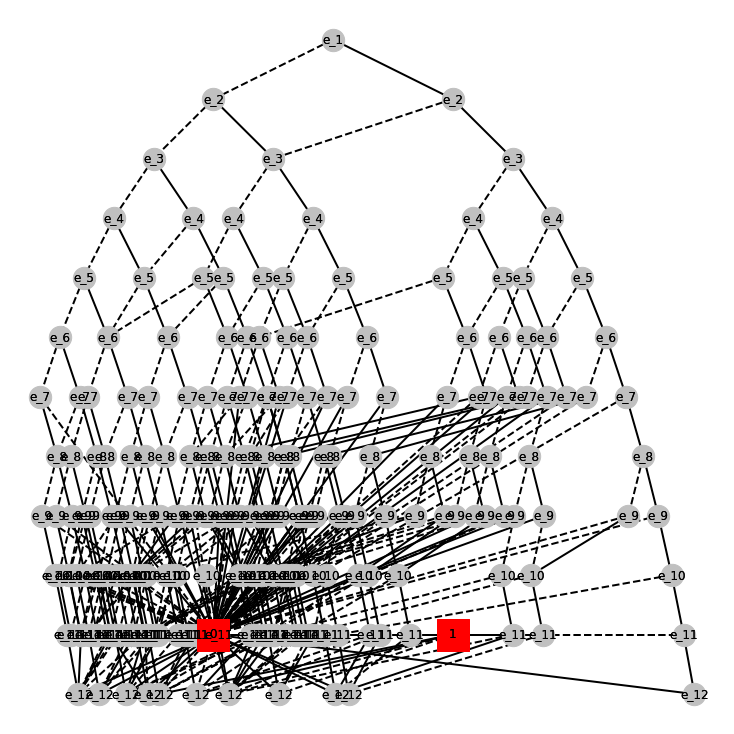

In [40]:
draw_ZDD(*ZDD_package)

In [41]:
%%time
print(f"There are {len(ZDD_package[0].nodes)} nodes with paths to count")
count_paths(*ZDD_package)

239it [00:00, 23979.49it/s]

There are 239 nodes with paths to count
CPU times: user 12.6 ms, sys: 2.76 ms, total: 15.3 ms
Wall time: 13.2 ms


258

## messing around with stuff

In [42]:
ZDD, node_labels, edge_labels, pos = ZDD_package

In [43]:
paths_labels = {node:node if type(node) is int else node.paths for node in node_labels.keys()}

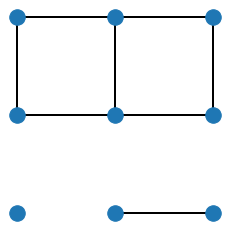

In [44]:
def get_edge(G, node, node_labels):
    label = node_labels[node]
    idx = int(label.split("_")[-1]) - 1
    return list(G.edges())[idx]

retained_edges = []
root_node = [n if node_labels[n]=='e_1' else None for n in node_labels.keys()][0] # dumb way to do it
processing = True
parent_node = root_node
while processing:
    [dismissed_child] = [c for (p, c) in edge_labels.keys() if p == parent_node and edge_labels[(p,c)] == '0'] # maybe dumb way to do it
    [retained_child] = [c for (p, c) in edge_labels.keys() if p == parent_node and edge_labels[(p,c)] == '1']

    paths_if_retain = retained_child if type(retained_child) is int else retained_child.paths
    probability_of_retaining = paths_if_retain / parent_node.paths

    if random.random() < probability_of_retaining:
        retained_edges.append(get_edge(G, parent_node, node_labels))
        parent_node = retained_child
    else:
        parent_node = dismissed_child
    if parent_node == 1:
        processing = False
        
new_G = nx.create_empty_copy(G)
new_G.add_edges_from(retained_edges)
tl.draw(new_G)

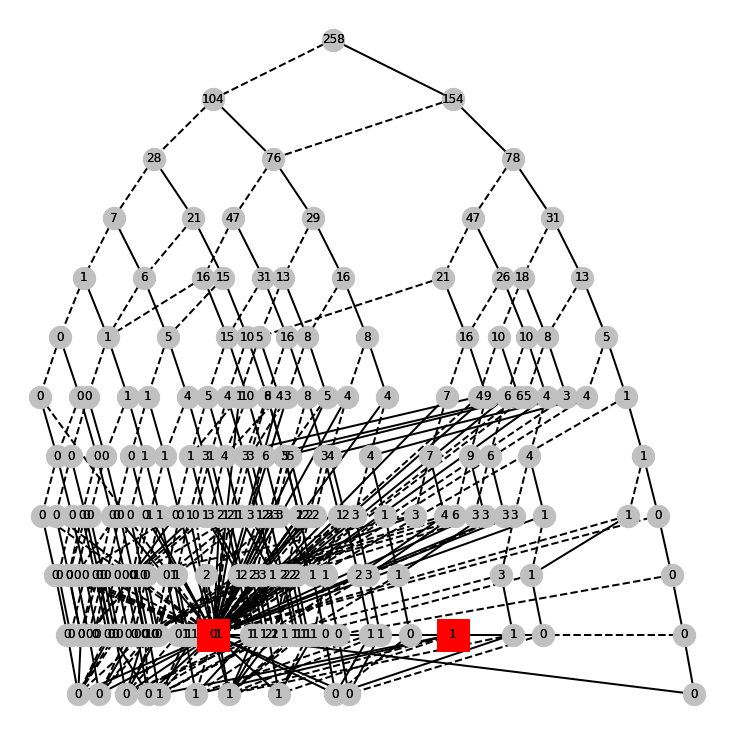

In [45]:
draw_ZDD(ZDD, paths_labels, edge_labels, pos)

In [46]:
list(ZDD_package[0].nodes())[0].paths

258